In [193]:
#This code was written to accompany the paper titled "Using Neural Networks To Guide Data-Driven Operational Decisions"

In [31]:
#We first import the necessary packages.
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import csv
import random
import numpy as np
from sklearn.model_selection import train_test_split
import datetime
#We now generate the covariate x and the decision variable z, along with our function (f_*) deonted target.
x=np.random.uniform(-10, 10, 50000)
z=np.random.uniform(-10, 10, 50000)
target=(x-z)**2
#We create a data set from our variables
df=np.vstack([x,z, target]).transpose()
df= pd.DataFrame(df)
#We write the dataset into a csv file
df.to_csv("grad-50k-%s.csv" % 1, sep=',', header=False, float_format='%.4f', index=False)

We now load the training data.

In [194]:
#We read the data set from a designated folder. You can use our provided data, or generate your own dataset using the previous block. 
df=np.array(list(csv.reader(open('grad-50k-%s.csv' % 1)))).astype("float")
df= pd.DataFrame(data=df, columns=["x","z", "target"])
data=df

We will split the data for training and testing. The data needs to be standardized.

In [195]:
#We fix the random seed to ensure reproducability of the results/
X=data.iloc[:,:-1].values
Y=data.iloc[:,-1].values
Y=Y.reshape(-1,1)
torch.manual_seed(1000)
random.seed(1000)
np.random.seed(1000)
from sklearn.preprocessing import StandardScaler
#X=X[:,:12]
m1=np.mean(X[:,0])
s1=np.std(X[:,0])
m2=np.mean(X[:,1])
s2=np.std(X[:,1])
StandardScaler=StandardScaler()
X=StandardScaler.fit_transform(X)
X = torch.from_numpy(X)
Y = torch.from_numpy(Y)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=1000+0)

In [35]:
#We define a neural network with 3 hidden layers and 3 swish nodes in each layer.
torch.manual_seed(1000)
random.seed(1000)
np.random.seed(1000)
model = torch.nn.Sequential(
    torch.nn.Linear(2, 3),
    torch.nn.SiLU(),
    torch.nn.Linear(3, 3),
    torch.nn.SiLU(),
    torch.nn.Linear(3, 3),
    torch.nn.SiLU(),
    torch.nn.Linear(3, 1),
)
loss_fn = torch.nn.MSELoss()
learning_rate = 10**(-4)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=.9, nesterov=True)



In [36]:
torch.manual_seed(1000)
random.seed(1000)
np.random.seed(1000)
#We train our network for a number of epochs, outputing the error on the test set.
for t in range(15000):
    y_pred = model(X_train.float())

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, Y_train.float())
    
    torch.manual_seed(1000)
    random.seed(1000)
    np.random.seed(1000)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % 1000 == 999:
        acc = loss_fn(Y_test, model(X_test.float())).item()
        print(acc)




6.45474060117534
43.29360054383916
3.781965844706379
6.141703724800016
3.0531444456808154
2.9273750813191133
91.4338358515202
3.9589557626615015
2.908220826860803
2.9947736570707364
2.6179334111016432
2.420148757225152
56.98777401917363
2.694011529940002
2.4118488504519604


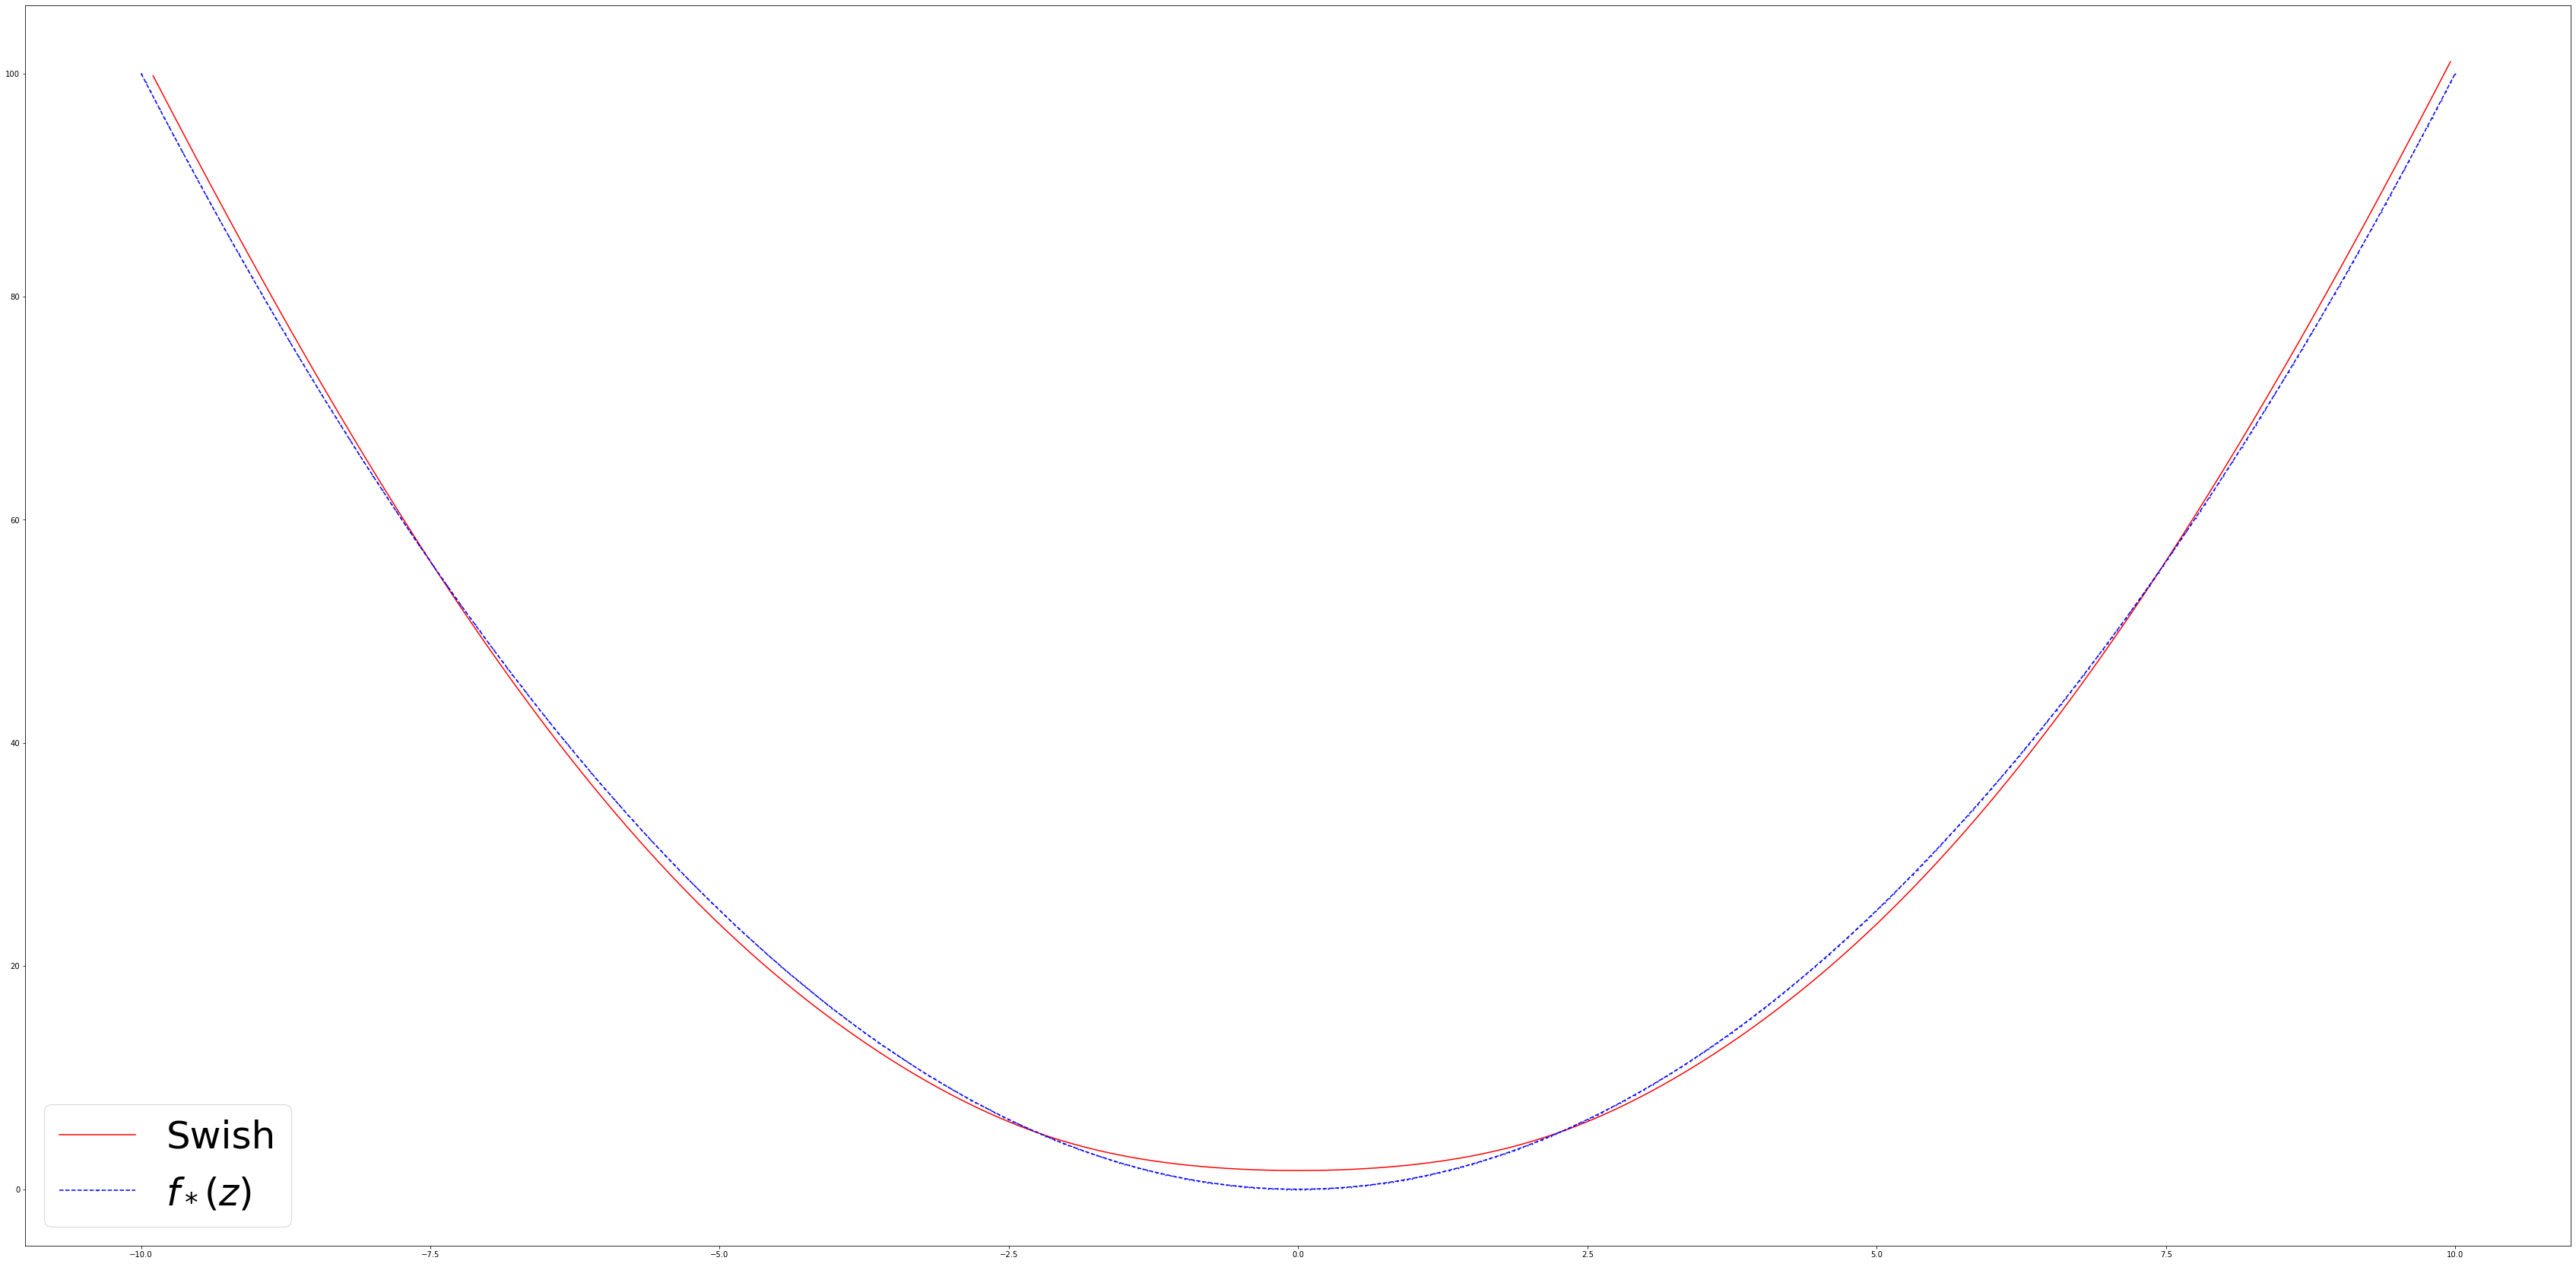

In [81]:
#We now plot the prediction value of the NN compared to the actual value of f_* to evaluate how well the NN generalizes to the data
import matplotlib.pyplot as plt
torch.manual_seed(1000)
random.seed(1000)
np.random.seed(1000)
fig = plt.figure()
ax = plt.axes()
qq=np.linspace(-1.72,1.72,2000)
aa=np.random.uniform(-m1/s1, -m1/s1,2000)
aq=(qq)*s2 + m2
x2=np.vstack([aa,qq]).transpose()
x2=torch.from_numpy(x2)
plt.rcParams["figure.figsize"] = (60,30)
y1=model(x2.float()).detach().numpy()
ax.plot(aq, y1, color='red',  label="Swish")
z = np.linspace(-10, 10, 500)
zz=z**2
ax.plot(z, zz, color='blue', linestyle='--', marker='o', markerfacecolor='blue', markersize=1, label="$f_*(z)$")
plt.legend(loc="lower left",fontsize=50)
plt.show()

In [67]:
torch.set_printoptions(precision=4)

In [68]:
#Printing the fitted NN parameters.
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print(layer.state_dict()['weight'])
        print(layer.state_dict()['bias'])

tensor([[-1.7124,  1.7100],
        [ 0.0081, -0.0080],
        [ 1.7235, -1.7209]])
tensor([-1.6824,  1.3022, -1.7184])
tensor([[ 4.6518,  1.9831,  4.5889],
        [ 0.2762, -1.0031, -0.2200],
        [-1.4228,  3.8292, -1.4879]])
tensor([ 2.3721, -2.2213,  3.6026])
tensor([[ 1.4862, -1.1508, -5.0347],
        [-0.1134, -0.1684, -0.1325],
        [ 4.0344, -0.6634, -1.0397]])
tensor([2.4532, 0.1484, 2.0276])
tensor([[2.1921, 0.8658, 3.2429]])
tensor([0.9145])


In [138]:
#We now take the parameters of the fitted NN, to calculate its gradient with respect to the input in closed form.
#This has to be fed manually from the fitted NN.
W1=[[-1.7124,  1.7100],
        [ 0.0081, -0.0080],
        [ 1.7235, -1.7209]]
W1z=[1.7100, -0.0080,  -1.7209]

b1=[-1.6824,  1.3022, -1.7184]

W2=[[4.6518,  1.9831,  4.5889],
        [ 0.2762, -1.0031, -0.2200],
        [-1.4228,  3.8292, -1.4879]]

b2=[ 2.3721, -2.2213,  3.6026]

W3=[[ 1.4862, -1.1508, -5.0347],
        [-0.1134, -0.1684, -0.1325],
        [ 4.0344, -0.6634, -1.0397]]

b3=[2.4532, 0.1484, 2.0276]

W4=[2.1921, 0.8658, 3.2429]

b4=0.9145

In [139]:
#We define the necessary functions for the gradient calculation
def sw(x):
    return x/(1+np.exp(-x))
def swm(x):
    return [x[0]/(1+np.exp(-x[0])),x[1]/(1+np.exp(-x[1])),x[2]/(1+np.exp(-x[2]))]
def dsw(x):
    return 1/(1+np.exp(-x))+ (x/(1+np.exp(-x)))*(1-1/(1+np.exp(-x)))

In [155]:
#We want to calculate the gradient at the point where x=0. For other points, please modify.
def jacob(x):
    x=x[0]
    p=[-m1/s1,x]
    inp1=np.matmul(W1,p)+b1
    out1=swm(inp1)
    inp2=np.matmul(W2,out1)+b2
    out2=swm(inp2)
    inp3=np.matmul(W3,out2)+b3
    out3=swm(inp3)
    out4=np.dot(W4, out3)+b4
    der1=[[dsw(inp1[0]),0,0],[0,dsw(inp1[1]),0],[0,0,dsw(inp1[2])]]
    der2=[[dsw(inp2[0]),0,0],[0,dsw(inp2[1]),0],[0,0,dsw(inp2[2])]]
    der3=[[dsw(inp3[0]),0,0],[0,dsw(inp3[1]),0],[0,0,dsw(inp3[2])]]
    g=np.matmul(der1,W1z)
    g=np.matmul(W2,g)
    g=np.matmul(der2,g)
    g=np.matmul(W3,g)
    g=np.matmul(der3,g)
    g=np.dot(W4, g)
    return g

In [143]:
#This is an alternative method of calculating the gradient using auto grad functions built into Tensorflow.
def jacob_auto(x):
    XX=[-m1/s1,x]
    XX=torch.FloatTensor(XX)
    XX.requires_grad = True
    model(XX).backward()
    return XX.grad[1].item()

In [173]:
#Now we find the optimal z that leads to the minimum prediction value for the trained NN.
import time
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import SR1
start = time.time()
def rosen(x):
        x=[-m1/s1,x]
        x=torch.FloatTensor(x)
        return np.asscalar(model(x))
pre=10000000  
bounds = Bounds([-2],[2])
for l in range (1):
        x0=[-2+(.04*l)]
        res = minimize(rosen, x0, method='trust-constr', jac=jacob, hess=SR1(),
            options={'verbose': 1}, bounds=bounds)
        cost=rosen(res.x)
        if (cost<pre):
            Oq=res.x
            pre=cost

end = time.time()
print(end-start)

`xtol` termination condition is satisfied.
Number of iterations: 99, function evaluations: 108, CG iterations: 87, optimality: 1.37e-04, constraint violation: 0.00e+00, execution time:  0.1 s.
0.10782170295715332


C:\Users\SAMAN~1.LAG\AppData\Local\Temp/ipykernel_35160/3603740324.py:10: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return np.asscalar(model(x))


In [174]:
-m1/s1

0.001444912531645366

In [175]:
#This is the optimal solution for x=0 (strandrdizing it becomes -m1/s1).
Oq

array([-0.00552324])

In [197]:
#We evaluate the autograd gradien at [1,1]
x=[-m1/s1,-0.0055]
x=torch.FloatTensor(x)
x.requires_grad = True
model(x).backward()
print(x.grad)

tensor([-0.0016,  0.0013])


In [168]:
#We redefine the jacob function to evaluate it at [1,1]
def jacob1(x):
    x=x[0]
    p=[1,x]
    inp1=np.matmul(W1,p)+b1
    out1=swm(inp1)
    inp2=np.matmul(W2,out1)+b2
    out2=swm(inp2)
    inp3=np.matmul(W3,out2)+b3
    out3=swm(inp3)
    out4=np.dot(W4, out3)+b4
    der1=[[dsw(inp1[0]),0,0],[0,dsw(inp1[1]),0],[0,0,dsw(inp1[2])]]
    der2=[[dsw(inp2[0]),0,0],[0,dsw(inp2[1]),0],[0,0,dsw(inp2[2])]]
    der3=[[dsw(inp3[0]),0,0],[0,dsw(inp3[1]),0],[0,0,dsw(inp3[2])]]
    g=np.matmul(der1,W1z)
    g=np.matmul(W2,g)
    g=np.matmul(der2,g)
    g=np.matmul(W3,g)
    g=np.matmul(der3,g)
    g=np.dot(W4, g)
    return g

In [198]:
jacob([-0.0055])

0.0009750472553069761

In [199]:
(Oq*s2)+m2

array([-0.00067486])